# Sentinel 2 preprocessing with rasterio

In [12]:
import rasterio
from matplotlib import pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.coords import BoundingBox
from rasterio.features import geometry_mask
import geopandas as gpd


Load an S2 image

In [2]:
dir = "Downloads"
#path = 'zip+file:///Downloads/S2A_MSIL2A_20170420T103021_N0204_R108_T32UNB_20170420T103454.zip!/S2A_MSIL2A_20170420T103021_N0204_R108_T32UNB_20170420T103454.SAFE/GRANULE/L2A_T32UNB_A009543_20170420T103454/IMG_DATA/R10m/L2A_T32UNB_20170420T103021_B04_10m.jp2'
path = r'C:\Users\Kostas\Downloads\S2A_MSIL2A_20170420T103021_N0204_R108_T32UNB_20170420T103454.SAFE\GRANULE\L2A_T32UNB_A009543_20170420T103454\IMG_DATA\R10m\L2A_T32UNB_20170420T103021_B08_10m.jp2'


Load the buffers. Again, when GeoPandas loads them it thinks that they are in WGS84, so `set_geometry` must be used

In [3]:
buffers = gpd.read_file(r'C:\Users\Kostas\Desktop\GIMA\Module_7\Data\PEP725\After_2016_sent_from_PEP725\pep725_outputs\pep725_high_count_days\buffers_day_92.geojson')
buffers.set_crs(32632, inplace=True, allow_override=True)

,s_id,lon,lat,alt,alt_dem,gss_id,genus,species,phase_id,year,day,date,Label,geometry
0,21405,11.81670,53.5833,55,56,1010300,Acer,Acer platanoides,60,2017,92,2017-04-02,DBL,"POLYGON ((690450.224 5940850.354, 690430.963 5..."
1,5054,12.55000,53.0667,50,57,10000,perm_grass,None,182,2017,92,2017-04-02,M,"POLYGON ((741832.253 5885583.114, 741812.992 5..."
2,19310,6.93333,51.1500,40,42,2030100,Picea,Picea abies,10,2017,92,2017-04-02,EC,"POLYGON ((359457.334 5668536.249, 359438.073 5..."
3,20640,12.23330,47.9667,475,472,1050100,Alnus,Alnus glutinosa,11,2017,92,2017-04-02,DBL,"POLYGON ((745331.682 5317659.346, 745312.421 5..."
4,21391,7.13333,50.6333,220,185,1580100,Fraxinus,Fraxinus excelsior,60,2017,92,2017-04-02,DBL,"POLYGON ((371991.300 5610710.490, 371972.039 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,4822,14.58330,51.7333,80,66,1180100,Betula,Betula pendula,60,2017,92,2017-04-02,DBL,"POLYGON ((889427.773 5746140.860, 889408.512 5..."
450,4846,13.05000,53.0333,70,57,2290100,Sorbus,Sorbus aucuparia,11,2017,92,2017-04-02,DBL,"POLYGON ((775525.271 5883647.870, 775506.010 5..."
451,4851,14.65000,51.8833,55,46,1010300,Acer,Acer platanoides,60,2017,92,2017-04-02,DBL,"POLYGON ((892733.038 5763159.776, 892713.777 5..."
452,4851,14.65000,51.8833,55,46,1580100,Fraxinus,Fraxinus excelsior,60,2017,92,2017-04-02,DBL,"POLYGON ((892733.038 5763159.776, 892713.777 5..."


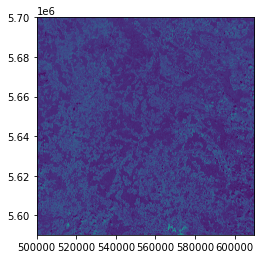

In [5]:
# with rasterio.open(path, driver='JP2OpenJPEG') as src:
#     show(src)


In [4]:
envelope_gdf = buffers.geometry.envelope

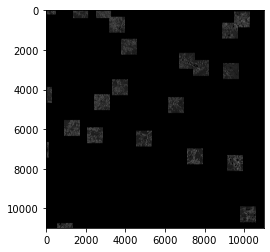

In [8]:
# Open the raster dataset
with rasterio.open(path, driver='JP2OpenJPEG') as src:
    # Read the data
    data = src.read()
    # Clip the raster dataset with the GeoDataFrame
    clipped_image, clipped_transform = mask(src, envelope_gdf.geometry)
    # Plot the clipped raster
    plt.imshow(clipped_image[0], cmap='gray')
    plt.show()





In [16]:
with rasterio.open(path, driver='JP2OpenJPEG') as src:
    # Read the data
    data = src.read(indexes=1)

     # Remove extra dimensions from the data array
    data = data.squeeze()
    
    # Get the bounding box of the raster
    bbox = BoundingBox(*src.bounds)

    # Clip the features in the extent_gdf GeoDataFrame to the bounding box
    clipped_gdf = envelope_gdf.copy()
    clipped_gdf['geometry'] = geometry_mask(clipped_gdf, bbox, src.transform, invert=True)

    # Loop over the features in the extent_gdf GeoDataFrame
    for i, feature in clipped_gdf.iterrows():
        # Clip the raster with the current feature
        clipped_image, clipped_transform = mask(src, [feature.geometry], nodata=src.nodata)
    
    # Save the clipped raster to a file
    with rasterio.open(f"output_{i}.tiff", "w", driver="GTiff",
                       height=clipped_image.shape[1], width=clipped_image.shape[2],
                       count=src.count, dtype=src.dtypes[0], crs=src.crs,
                       transform=clipped_transform) as dst:
        dst.write(clipped_image)

ValueError: Invalid out_shape, must be 2D